# **1. Data collection**
**1.1. Get the list of places**

In [4]:
# Import the modules we need
import httplib2
import requests
from bs4 import BeautifulSoup
import re
import datetime
import numpy as np
import time
import urllib.request, urllib.parse, urllib.error
import os
import random
from tqdm import tqdm
import csv
import string
import heapq
import functools
import json
import math
from numpy.linalg import norm
from natsort import natsorted
import glob
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# URL definition
linkPre = 'https://www.atlasobscura.com/places?page='
linkPost = '&sort=likes_count'
pageLink = []

In [ ]:
# Write a function to extract the URLs that we need from the pages
def extractAllLinks(firstPage, lastPage, linkPre, linkPost):
  allLinks = []
  for i in range(firstPage, lastPage + 1):
    pageLink = linkPre + str(i) + linkPost #Generate the url where we need to get the place url on it.
    html = requests.get(pageLink).text #return the content of the page
    soup = BeautifulSoup(html, 'html.parser').find_all("a" , attrs={'href': re.compile("^/places/")})
    links = [link.get('href') for link in soup]
    links = links[10:]  # Delete the first 9 links at the bottom of the page that we don't need
    time.sleep(0.5)
    for item in links:
      if (item != None): 
            allLinks.append(('https://www.atlasobscura.com' + str(item)))
            for link in allLinks:
              if link == "https://www.atlasobscura.com/places/new":  # Delete the URLs that we don't need
                allLinks.remove("https://www.atlasobscura.com/places/new")
            
         

  return allLinks  

We don't have any duplicate link in the link_set file. Because length of list & length of Set are the same.

In [ ]:
link_set = extractAllLinks(1, 400, linkPre, linkPost)
len(link_set) == len(set(link_set)) # Check if there is any duplicate or not

True

The total number of the URLs is 7200

In [ ]:
len(link_set)

In [ ]:
# Save the URLs of the places' pages in a file
with open('drive/MyDrive/ADM/Homework3/link_set.txt','w',encoding = 'utf-8') as f:
    for i in link_set:
        f.write(i+'\n')

f.close # Finally, we saved links at local directory.

<function TextIOWrapper.close()>

**1.2. Crawl places**

Due to a large number of pages we should download, we can use some methods that can help us shorten the time it takes. 

***Time:*** First, we can work in parallel with our group's members, using the same code, each member of the group should download a subset of pages and when we obtained all the pages, merge our results into one unique dataset. Second, we can generate our code in parallel with all the CPUs available in our computer. 

***Data:*** In addittion, we have to save our data each time we crawl a page and write the name of the file according to the number of articles that we have already downloaded. In this way, if something goes wrong, we can restart your crawling procedure from the point that it stopped.

In [ ]:
# The function that gets the html of a url 
def getHtml(url):  
    global html
    try:
        red = urllib.request.urlopen(url,timeout=30)
        html = red.read()
        red.close()
    except:
        getHtml(url)
    return html

In [ ]:
# input file name(path) and html, save it to local disk 
def saveHtml(file_name, file_content): # save the html
    with open(file_name+".html", "wb") as f:
        f.write(file_content)
    f.close

In [ ]:
# Convert the link_set to a list
link = list(link_set)

In [ ]:
for i in tqdm(range(1,2)): #You can change the number here for part data set; you need to replace it by your data range. 
    path = 'drive/MyDrive/ADM/Homework3/Data/' + str(i+1) # The path we store the htmls
    os.mkdir(path) # For each page, we creat a folder. We have 400 pages so we creat 400 folders.
    for j in range(i*18,(i+1)*18): # Count the number of files in each folder.
        htmlTemp = getHtml(link[j])
        saveHtml(path+'/Place '+str(j+1), htmlTemp)
        time.sleep(0.5) 

**1.3. Parse downloaded pages**

In [ ]:
# The function we used to get info from html
def getinfo(html_path):
  with open(html_path,'r',encoding = 'utf-8') as f:
    text = f.read()
  f.close
  return text

In [ ]:
# The function that extracts the required info
def extract_infos(html, i):
    '''
    Function that extract the useful informations from an url and place them in a list. The order of the list is:
    placeName, placeTags, numPeopleVisited, numPeopleWant, placeDesc, placeShortDesc, placeNearby, placeAddress, 
    placeAlt, placeLong, placeEditors, placePubDate, placeRelatedLists, placeRelatedPlaces, placeURL.
    The output is the list.
    '''
    soup = BeautifulSoup(html)
    
    #initiliaze the empty output list
    infos = []
    
    #append infos in the right order
    
    try:
      placeName = soup.find_all('h1', {'class':'DDPage__header-title'})[0].contents[0]
      infos.append(placeName)
    except:
       infos.append('') 
    
    try:
      placeTags = [x.contents[0] for x in soup.find_all('a', {'class':'itemTags__link js-item-tags-link'})]
      for i in range(len(placeTags)):
        placeTags[i] = placeTags[i].replace("\n", "")
      infos.append(placeTags)
    except:
       infos.append('') 
    
    try:
      numPeopleVisited = soup.find('div', {'class':'col-xs-4X js-submit-wrap js-been-to-top-wrap action-btn-col hidden-print'}).find_all('div', {'class': 'title-md item-action-count'})[0].contents[0]
      infos.append(int(numPeopleVisited))
    except:
      infos.append('')  
    
    try:
      numPeopleWant = soup.find('div', {'class':'col-xs-4X js-submit-wrap js-like-top-wrap action-btn-col hidden-print'}).find_all('div', {'class': 'title-md item-action-count'})[0].contents[0]
      infos.append(int(numPeopleWant))
    except:
      infos.append('')
    
    try:
      placeDesc = [x.text for x in soup.find_all('div', {'id':'place-body'})]
      placeDesc[0] = placeDesc[0].replace("\n" , " ")
      placeDesc[0] = placeDesc[0].replace("\xa0" , " ")
      infos.append(placeDesc[0])
    except:
      infos.append('')  
    
    try:
      placeShortDesc = soup.find_all('h3', {'class':'DDPage__header-dek'})[0].contents[0]
      placeShortDesc = placeShortDesc.replace("\xa0" , " ")
      infos.append(placeShortDesc)
    except:
      infos.append('')

    
    try:
      placeNearby = [x.text for x in soup.find_all('div', {'class':'DDPageSiderailRecirc__item-title'})]
      infos.append(placeNearby)
    except:
      infos.append('')

    
    placeAlt, placeLong = soup.find_all('div', {'class': 'DDPageSiderail__coordinates js-copy-coordinates'})[0].contents[2].split(',')

    try:
      add = soup.find('address', {'class': 'DDPageSiderail__address'}).find('div', recursive=False)
      for child in add.find_all("div"):
          child.decompose()
      placeAddress = add.get_text(" ")
      placeAddress = placeAddress.replace("\n" , "")
      infos.append(placeAddress)
    except:
      infos.append('')


    
    try:
    # As we decompose the div tags in "placeAddress" part, we find the placeAlt and placeLong before placeAddress but append it after that.
      infos.append(str(float(placeAlt)))
      infos.append(str(float(placeLong)))
    except:
      infos.append('')  

    
    try:
      contributors = soup.find_all('a', {'class':'DDPContributorsList__contributor'})
      placeEditors = [x.contents[0] if x.contents[0] != '\n' else x.span.contents[0] for x in contributors]
      infos.append(placeEditors)
    except:
      infos.append('')  
    
    try:
      date = soup.find_all('div', {'class':'DDPContributor__name'})[0].contents[0]
      placePubDate = datetime.datetime.strptime(date,'%B %d, %Y')
      infos.append(placePubDate)
    except:
      infos.append('')  
    
    try:
      placeRelatedLists = [x.span.text for x in soup.find('div', {'data-gtm-template': 'DDP Footer Recirc Lists'}).find_all('h3', {'class':'Card__heading --content-card-v2-title js-title-content'})]
      infos.append(placeRelatedLists)
    except:
      infos.append('')
    
    try:
      placeRelatedPlaces = [x.span.text for x in soup.find('div', {'data-gtm-template': 'DDP Footer Recirc Related'}).find_all('h3', {'class':'Card__heading --content-card-v2-title js-title-content'})]
      infos.append(placeRelatedPlaces)
    except:
      infos.append('')


    with open('drive/MyDrive/ADM/Homework3/link_set.txt','r',encoding = 'utf-8') as f:
        
        j = 1
        global line
        while j <= i: 
            line = f.readline()
            j+=1
        placeUrl = line
        
    infos.append(placeUrl)
    
    return infos

In [ ]:
# For each place, we create a place_i.tsv file and put infos on it
#The list of headers, we desire for each featur
header = ['placeName', 'placeTags', 'numPeopleVisited','numPeopleWant', 'placeDesc', 'placeShortDesc', 'placeNearby', 
          'placeAddress', 'placeAlt', 'placeLong', 'placeEditors', 'placePubDate', 'placeRelatedLists', 'placeRelatedPlaces', 'placeURL']
for i in tqdm(range(15,16)): # We can easily change this range and download the infos
    #retrieve html code
    folder = math.ceil(i / 18)
    path = 'drive/MyDrive/ADM/Homework3/Data/' + str(folder) + '/Place '+ str(i) + '.html'
    html = getinfo(path)    
    #extract infos
    place_data = extract_infos(html, i)

    #write tsv file
    # Title of the future tsv file
    title = 'drive/MyDrive/ADM/Homework3/places_data/' + 'places_'+ str(i)+'.tsv'
    with open(title, "w", newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        # write the header
        writer.writerow(header)
        #write the infos
        writer.writerow(place_data)


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


# **2. Search Engine**

In [ ]:
# Put all tsv files into one file
all_filenames = natsorted(glob.glob('./drive/MyDrive/ADM/Homework3/places_data/*'))
combinedTsv = pd.concat([pd.read_csv(f, delimiter= '\t') for f in all_filenames], ignore_index=True)

In [ ]:
path = 'drive/MyDrive/ADM/Homework3/'
#os.mkdir(path+"queryData")
combinedTsv.to_csv(path+'queryData/combinedTsv.tsv', sep='\t')

In [ ]:
#show the first 5th rows
combinedTsv.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL
0,City Hall Station,"['subways', 'subterranean', 'infrastructure', ...",1828,8585,The first New York City subway was built and...,A beautiful and abandoned New York subway stat...,"['African Burial Ground National Monument', 'T...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"['Rebekah Otto', 'mbison', 'Seth Teicher', 'er...",2010-05-08 00:00:00,['30 Unexpected Places to Have a Joyful Advent...,"['Crystal Palace Subway', 'Moscow Metro Statio...",https://www.atlasobscura.com/places/evolution-...
1,Highgate Cemetery,"['rivals week', 'vampires', 'hoaxes', 'occult'...",2619,8184,"Opened in 1839, Highgate is one of London’s ...",London's creepiest cemetery was once the site ...,"[""World's Largest Potted Plant"", 'Dick Whittin...","Swain's Lane, Highgate London, England, N6 Uni...",51.5675,-0.1483,"['gingercinnamon', 'Rachel', 'thedyerghoulhous...",2014-08-09 00:00:00,"[""The World's Top 100 Wonders in 2018"", ""Londo...","['Jewett City Vampires', 'Tomb of the Mather F...",https://www.atlasobscura.com/places/evolution-...
2,Leadenhall Market,"['markets', 'film locations', 'film']",3135,7570,The ornate 19th-century painted roof and cob...,This ornate Victorian marketplace was the sett...,"['The Cornhill Devils ', ""London's Original an...","London, England, EC3V United Kingdom",51.5126,-0.0834,"['Meg', 'Julius Spada', 'reley250', 'Katecrims...",2016-08-01 00:00:00,"['The Ultimate Guide to Stunning, Surprising, ...","['Rivendell', 'Bagdad Cafe', 'Gare de la Ciota...",https://www.atlasobscura.com/places/highgate-c...
3,The Wave Organ,"['sea organ', 'aletrail', 'sounds', 'music', '...",2429,7414,"Located on a jetty in the San Francisco Bay,...",A huge musical instrument played by the ocean.,"['Long Now Orrery', 'The Stern of the Briganti...","83 Marina Green Dr San Francisco, California, ...",37.8085,-122.4401,"['mbison', 'jadeimason', 'td007', 'Mark Casey'...",2008-11-21 00:00:00,"[""Leonardo Nam's 16 Quirky Roadside Attraction...","['Sea Organ', 'Silent Green Kulturquartier', ""...",https://www.atlasobscura.com/places/evolution-...
4,Catacombes de Paris,"['ossuaries', 'memento mori', 'catacombs and c...",4448,7047,"In 2004, Parisian police were assigned to do...","The vast, legendary catacombs hold secrets muc...","['Sculptures de Décure', 'Arago Medallions', ""...","1 Place Denfert-Rochereau Paris, 75014 France",48.8343,2.3322,"['CPilgrim', 'ehorkley', 'gingercinnamon', 'Ak...",2009-02-13 00:00:00,"['19 Catacombs Sure to Tingle Your Spine', ""Th...","['Ossario di San Martino', 'Leuk Charnel House...",https://www.atlasobscura.com/places/leadenhall...


In [ ]:
# Information about the dataFram, we have 15 columns and 7200 rows
combinedTsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   placeName           7200 non-null   object 
 1   placeTags           7200 non-null   object 
 2   numPeopleVisited    7200 non-null   int64  
 3   numPeopleWant       7200 non-null   int64  
 4   placeDesc           7200 non-null   object 
 5   placeShortDesc      7200 non-null   object 
 6   placeNearby         7200 non-null   object 
 7   placeAddress        7200 non-null   object 
 8   placeAlt            7200 non-null   float64
 9   placeLong           7200 non-null   float64
 10  placeEditors        7200 non-null   object 
 11  placePubDate        7199 non-null   object 
 12  placeRelatedLists   2721 non-null   object 
 13  placeRelatedPlaces  7164 non-null   object 
 14  placeURL            7200 non-null   object 
dtypes: float64(2), int64(2), object(11)
memory usage: 843.9

In [ ]:
# Pick the columns that we need in this part
combinedTsv = combinedTsv[['placeName', 'placeDesc', 'placeAddress', 'placeURL']]

In [ ]:
path = 'drive/MyDrive/ADM/Homework3/'

In [ ]:
os.mkdir(path+"queryData")

In [ ]:
# converting dataframe to csv file
combinedTsv.to_csv(path+'queryData/queryData.csv', sep=',',
                   index=False, header=True)

In [ ]:
# Read csv file
"""
For convenience, the cleaned, processed, desired query data is saved in a file 
named queryData.csv. You can directly go to section '2.1. Conjunctive query' and 
import the query data from there.
"""
queryData = pd.read_csv(path+'queryData/queryData.csv')

In [5]:
queryData = pd.read_csv('queryData.csv')

In [6]:
# Import the useful modules for processing the documents' sentences 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/smndrs/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/smndrs/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
# Function for stemming, and removing stopwords and punctuation
def preProcess(word):
    
    filteredWords = []
    stopWords = set(stopwords.words("english"))
    punc =  set(string.punctuation)  
    wordTokens = word_tokenize(word)
    ps = PorterStemmer()
    
  
    for w in wordTokens:
        if (w.lower() not in stopWords) and (w not in punc) :
            filteredWords.append(ps.stem(w))  
            
    return filteredWords

In [8]:
# Preprocess the places' descriptions and put them in a list
wordsInDocs = []
for i in queryData['placeDesc']:
    wordsInDocs.append(preProcess(str(i)))

In [9]:
# Taking a copy of the original query data to work on from now on
queryDataCopy = queryData.copy()

In [10]:
# Add a new column (wordsInDocs) to the query data
queryDataCopy['wordsInDocs'] = wordsInDocs
queryDataCopy.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeNearby,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedLists,placeRelatedPlaces,placeURL,wordsInDocs
0,City Hall Station,"['subways', 'subterranean', 'infrastructure', ...",1828,8585,The first New York City subway was built and...,A beautiful and abandoned New York subway stat...,"['African Burial Ground National Monument', 'T...","31 Centre St New York, New York, 10007 United ...",40.7134,-74.0046,"['Rebekah Otto', 'mbison', 'Seth Teicher', 'er...",2010-05-08 00:00:00,['30 Unexpected Places to Have a Joyful Advent...,"['Crystal Palace Subway', 'Moscow Metro Statio...",https://www.atlasobscura.com/places/evolution-...,"[first, new, york, citi, subway, built, oper, ..."
1,Highgate Cemetery,"['rivals week', 'vampires', 'hoaxes', 'occult'...",2619,8184,"Opened in 1839, Highgate is one of London’s ...",London's creepiest cemetery was once the site ...,"[""World's Largest Potted Plant"", 'Dick Whittin...","Swain's Lane, Highgate London, England, N6 Uni...",51.5675,-0.1483,"['gingercinnamon', 'Rachel', 'thedyerghoulhous...",2014-08-09 00:00:00,"[""The World's Top 100 Wonders in 2018"", ""Londo...","['Jewett City Vampires', 'Tomb of the Mather F...",https://www.atlasobscura.com/places/evolution-...,"[open, 1839, highgat, one, london, ’, infam, c..."
2,Leadenhall Market,"['markets', 'film locations', 'film']",3135,7570,The ornate 19th-century painted roof and cob...,This ornate Victorian marketplace was the sett...,"['The Cornhill Devils ', ""London's Original an...","London, England, EC3V United Kingdom",51.5126,-0.0834,"['Meg', 'Julius Spada', 'reley250', 'Katecrims...",2016-08-01 00:00:00,"['The Ultimate Guide to Stunning, Surprising, ...","['Rivendell', 'Bagdad Cafe', 'Gare de la Ciota...",https://www.atlasobscura.com/places/highgate-c...,"[ornat, 19th-centuri, paint, roof, cobbl, floo..."
3,The Wave Organ,"['sea organ', 'aletrail', 'sounds', 'music', '...",2429,7414,"Located on a jetty in the San Francisco Bay,...",A huge musical instrument played by the ocean.,"['Long Now Orrery', 'The Stern of the Briganti...","83 Marina Green Dr San Francisco, California, ...",37.8085,-122.4401,"['mbison', 'jadeimason', 'td007', 'Mark Casey'...",2008-11-21 00:00:00,"[""Leonardo Nam's 16 Quirky Roadside Attraction...","['Sea Organ', 'Silent Green Kulturquartier', ""...",https://www.atlasobscura.com/places/evolution-...,"[locat, jetti, san, francisco, bay, wave, orga..."
4,Catacombes de Paris,"['ossuaries', 'memento mori', 'catacombs and c...",4448,7047,"In 2004, Parisian police were assigned to do...","The vast, legendary catacombs hold secrets muc...","['Sculptures de Décure', 'Arago Medallions', ""...","1 Place Denfert-Rochereau Paris, 75014 France",48.8343,2.3322,"['CPilgrim', 'ehorkley', 'gingercinnamon', 'Ak...",2009-02-13 00:00:00,"['19 Catacombs Sure to Tingle Your Spine', ""Th...","['Ossario di San Martino', 'Leuk Charnel House...",https://www.atlasobscura.com/places/leadenhall...,"[2004, parisian, polic, assign, train, exercis..."


In [ ]:
# Save queryDataCopy in a csv file
queryDataCopy.to_csv(path+'queryData/queryData.csv',
                     sep=',', index=False,header=True)

**2.1. Conjunctive query**

In [ ]:
""" As explained before, we can directly import the query data from here
 and skip the previous cells for creating it.
"""
# Here, we need to read the wordsInDocs column values as a list
# Since read_csv reads all values as string, we define a lambda func to get 
# wordsInDocs values as a list of strings.
queryDataCopy = pd.read_csv(path+'queryData/queryData.csv', sep=',',
                            converters={"wordsInDocs": lambda x: x.strip("[]").replace("'","").split(", ")})
wordsInDocs = list(queryDataCopy.wordsInDocs)

In [11]:
"""
Using reduce to compute sum of lists, put all words in one single list
and drop the duplicated words.
Like query data, you can skip to two cells below to import the saved uniquewords
that is already created and saved.
"""
uniqueWords = list(set(functools.reduce(lambda x, y: x + y,wordsInDocs)))

In [ ]:
# Writing unique words into a file; space seperated.
with open(path+'/uniqueWords.txt', 'w', encoding='utf-8') as file:
    for word in uniqueWords:
        file.write("%s " % word)

In [ ]:
# To check how many unique words exist
print(f"We have {len(uniqueWords)} unique words in all docs.")

We have 53108 unique words in all docs.


In [ ]:
# As explained before, we can directly import the unique words from here:
# skip this if you have run the above cell.
uniqueWords = []
with open(path+'/uniqueWords.txt', 'r', encoding='utf-8') as file:
  for line in file:
    uniqueWords = line.split()

**2.1.1) Create your index!**

In [12]:
# Make a dictionary, the keys are words and values are numbers between 1 to 53195
wordDict = {}
item_id = 1
for word in uniqueWords:
    wordDict[word] = item_id
    item_id += 1    

In [ ]:
# Create a file named vocabulary, with json format, that maps each word to an integer (term_id).
with open (path+'vocabulary.json', 'w',encoding = 'utf-8') as j:
    j.write(json.dumps(wordDict))

In [ ]:
# Skip the two cells above if you want to directly import the already 
# created and saved wordDict

# We import wordDict by converting values from string to int through a lambda
# function
wordDict = {}
with open (path+'vocabulary.json', 'r',encoding = 'utf-8') as j:
    wordDict = json.load(j, object_hook=lambda x: {k:int(v) for k,v in x.items()})

In [13]:
# Create the inverted index file that takes words indces as keys, and a list of
# documents containing the associated word, as the value.
inverted_idx = {}
for word, item_id in tqdm(wordDict.items()):
    indexDoc = queryDataCopy[queryDataCopy.wordsInDocs.apply(lambda row: word in row)].index
    inverted_idx[item_id] = list(indexDoc)

100%|█████████████████████████████████████| 53108/53108 [26:31<00:00, 33.36it/s]


In [ ]:
# Saving inverted_idx in a json file
import json
with open (path+'invertedIdx.json', 'w',encoding = 'utf-8') as j:
    j.write(json.dumps(inverted_idx))

In [ ]:
# Skip the two cells above if you want to directly import the already 
# created and saved inverted_idx

# We import inverted_idx by converting keys format from string to int 
# through a lambda function
inverted_idx = {}
with open (path+'invertedIdx.json', 'r',encoding = 'utf-8') as j:
    inverted_idx = json.load(j, object_hook=lambda x: {int(k):v for k,v in x.items()})

In [14]:
# Defining the first search engine
def SearchEngine(queryString, df):

    # Split the query into lists of words and stem the words
    stemTxt = preProcess(queryString)

    # Find the description id of the queryString(documents that contain the queryString)
    results = [set(inverted_idx[item]) for item in [wordDict[word] for word in stemTxt]]
    descId = functools.reduce(lambda x,y: x.intersection(y), results) #Set of ids
    queryInfo = df.loc[descId]
  
    return queryInfo


**2.1.2) Execute the query**

In [15]:
# Example output
querySample = input('Please enter the queryString: ')
SearchEngine(querySample, queryDataCopy)[['placeName','placeDesc','placeAddress','placeURL']]

Please enter the queryString:  city hall


/var/folders/_2/4hw_b5r17l139bnw2649h6yc0000gn/T/ipykernel_8865/3062576557.py:10: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  queryInfo = df.loc[descId]


,placeName,placeDesc,placeAddress,placeURL
0,City Hall Station,The first New York City subway was built and...,"31 Centre St New York, New York, 10007 United ...",https://www.atlasobscura.com/places/evolution-...
6145,Marché Bonsecours,The Marché Bonsecours is a large two-story p...,"350 St Paul St East Montreal, Québec Canada",https://www.atlasobscura.com/places/city-hall-...
512,New York Society Library,The New York Society Library occupies a 5-st...,"53 East 79th Street New York, New York United ...",https://www.atlasobscura.com/places/leadenhall...
7,Underground Tunnels of Los Angeles,While the rest of the country was forced to ...,"320 W Temple St Los Angeles, California, 90012...",https://www.atlasobscura.com/places/leadenhall...
6664,Warsaw Gasworks Museum,"Beautifully preserved, the Warsaw Gasworks (...",ul. Marcin Kasprzak 2 Warsaw Poland,https://www.atlasobscura.com/places/catacombes...
...,...,...,...,...
4597,Hippo Hardware,The happy hippos on the columns and walls ou...,"1040 E Burnside St Portland, Oregon United Sta...",https://www.atlasobscura.com/places/magowans-i...
503,Philadelphia's Moon Tree,"Philadelphia’s Washington Square Park, a blo...",Washington Square Park 6th Street and Walnut S...,https://www.atlasobscura.com/places/evolution-...
6137,Cine Ópera,"Cine Ópera was one of the largest, most gran...","9 Serapio Rendon Mexico City, 06470 Mexico",https://www.atlasobscura.com/places/wave-organ\n
3581,City Hall Urinal,There are plenty of public places to pee in ...,195-197 Oudezijds Voorburgwal Amsterdam Nether...,https://www.atlasobscura.com/places/leadenhall...


**2.2) Conjunctive query & Ranking score**

**TF-IDF Formula :**

**tf-idf** = term_frequency * inverse_document_frequency

**term_frequency** = number of times a given term appears in document

**inverse_document_frequency** = log(total number of documents / number of documents with term) 

In [ ]:
# Computing the inverted_idx2
from tqdm import tqdm
inverted_idx2 = {}
corpusSize = len(wordsInDocs)
for word in tqdm(inverted_idx.keys()):
    indx = int(word)
    Idf = math.log(corpusSize/len(inverted_idx[word]))
    tempList = []
    for doc in inverted_idx[word]:
        tempDoc = wordsInDocs[doc]
        Tf = tempDoc.count(list(wordDict)[indx-1])/len(tempDoc)
        TfIdf = Tf * Idf
        tempList.append((doc, TfIdf))
    inverted_idx2[indx] = tempList

100%|██████████| 53108/53108 [27:45<00:00, 31.89it/s]


In [ ]:
# Save the inverted-idx2 as json file
with open (path+'invertedIdx2.json', 'w',encoding = 'utf-8') as j:
    j.write(json.dumps(inverted_idx2))

In [ ]:
# We import inverted_idx2 by converting keys format from string to int 
# through a lambda function
with open (path+'invertedIdx2.json', 'r',encoding = 'utf-8') as j:
    inverted_idx2 = json.load(j, object_hook=lambda x: {int(k):v for k,v in x.items()})

In [ ]:
# Write a def to compute the tfIdf for the query
corpusSize = len(wordsInDocs) 
def ComputeQueryTfidf(query):
  tfidf = []
  for word in query:
    tfQuery = query.count(word) / len(query) # Compute tf
    idfQuery = math.log(corpusSize/len(inverted_idx[wordDict[word]])) # Compute Idf
    tfidf.append(tfQuery*idfQuery) # Compute tfIdfs and append them to a list
  return tfidf

In [ ]:
# Write a def for SearchEngine2 that return a list of documents, ranked by their Cosine Similarity to the queryString entered in the input.

def SearchEngine2(queryString, df):
  #Preprocessing the query
  stemQuery = preProcess(queryString)

  # Getting docs that have all the query words
  allDocs = SearchEngine(queryString, df)
  docsInd = allDocs.index

  # Getting indices of each word within stemmed query from vocabulary
  try:
    wordIndices = [wordDict[word] for word in stemQuery]
  except:
    print("No result found. The query words does not exist on the data base.")
    return 0
  
  # Getting tfidfs of the found docs from inverted_idx2
  resultDict = {doc:[] for doc in docsInd}
  for i in docsInd:
    for j in wordIndices:
      for k in inverted_idx2[j]:
        if k[0]==i:
          resultDict[i].append(k[1])
  
  # tfid of the  stemmed query
  tfidfQuery = ComputeQueryTfidf(stemQuery)

  # Computing cousing similarity
  cosinSimilarity = []
  for doc in resultDict.keys(): 
    cosin = np.dot(tfidfQuery,resultDict[doc])/(norm(tfidfQuery)*norm(resultDict[doc])) 
    cosinSimilarity.append(cosin)
  
  # Add a column that contain the cosin similarity for each document
  allDocs['cosin_similarity'] = cosinSimilarity
  # Rank by the cosin similarity
  allDocs.sort_values(by=['cosin_similarity'], inplace=True, ascending=False)

  # Return allDocs[['placeName','placeDesc','placeAddress','placeURL', cosin_similarity]]
  return allDocs

In [ ]:
# Example output ("city hall")
querySample2 = input('Please enter the queryString: ')
SearchEngine2(querySample2, queryDataCopy)

,placeName,placeDesc,placeAddress,placeURL,cosin_similarity
6909,Hamilton Ghost Town,After silver lodes were discovered high on T...,"White Pine County, Nevada United States",https://www.atlasobscura.com/places/highgate-c...,1.000000
1812,Nevadaville Ghost Town,How did the population of a 19th century tow...,"Nevadaville Rd, Central City, CO, USA Central ...",https://www.atlasobscura.com/places/magowans-i...,1.000000
3655,Parksville,"Located in the town of Liberty, New York, Pa...","Parksville, New York United States",https://www.atlasobscura.com/places/city-hall-...,1.000000
5204,Grímsey Island,Forty miles north of mainland Iceland is a s...,Vallargata Grímsey Iceland,https://www.atlasobscura.com/places/leadenhall...,1.000000
4006,Mayan Ruins on the Hudson,"In the mid-1800s, travelers moving up and do...","Cruger Island Road Red Hook, New York, 12571 U...",https://www.atlasobscura.com/places/highgate-c...,1.000000
...,...,...,...,...,...
3465,The Forgotten Entrance to Clinton Hall,This blocked up doorway on a subway station ...,Astor Place Subway Station Astor Place New Yor...,https://www.atlasobscura.com/places/wave-organ\n,0.701593
1050,Flushing Meadows-Corona Park,"After a long ride from Manhattan, most get o...","Kennedy Circle Queens, New York, 11368 United ...",https://www.atlasobscura.com/places/highgate-c...,0.667151
3559,Summum Pyramid,"In 1975, Claude Corky Nowell said he had an ...","707 Genesee Avenue Salt Lake City, Utah, 84104...",https://www.atlasobscura.com/places/wave-organ\n,0.639595
6903,The Caves of Nottingham,Underneath the modern city of Nottingham is ...,"Garner's Hill Nottingham, England United Kingd...",https://www.atlasobscura.com/places/evolution-...,0.617163


# **3. Define a new score!**

To understand our choices for this question, let's study better the use cases of this application. In our opinion the user will use this "application" when he wants to do a research to find places to visit (for example: next week I'm going to Milan and I want to search if there are any science museums there, or also this evening I want to do some new experiences in my city). In every case what's important is the location and the activity that you can do in the place.<br>
So, for us, a way to give more relevant outputs to the user is finding out where he want to go and what he wants to do (or particular topics in which he is interested). To do that we can ask the user to specify these information and we can exploit the ``placeAddress`` and ``placeTags`` columns to give more importance to the places that match the requests.<br>
Furthermore we could also ask the user to indicate some places nearby (useful if he is for example planning a trip), or some places similar, and then exploit the ``placeNearby`` and ``placeRelatedPlaces`` columns. But not all the users want to specify all these things, so as first thing we are going to ask the user whether he wants to do a basic research (where he has to give only the description of the place, where he wants to go and what he wants to do) or a more advanced research(where he is asked to indicate also the places nearby and places similar). In both cases he can skip some fields by putting a "-".

Now, we can see the code.<br>
First of all we have to prepare the dataset by stemming the columns of our interest.

In [16]:
#preparation of the dataset

#take only the columns of interest
#queryData_3 = pd.read_csv('queryData.csv', usecols = ['placeName', 'placeTags', 'placeDesc', 'placeNearby', 'placeAddress', 
                                                   #'placeRelatedLists', 'placeRelatedPlaces', 'placeURL'])
queryData_3 = pd.read_csv('queryData.csv', usecols = ['placeName', 'placeTags', 'placeDesc', 'placeNearby', 'placeAddress', 'placeAlt', 'placeLong', 'numPeopleVisited',
                                                   'numPeopleWant','placeRelatedLists', 'placeRelatedPlaces', 'placeURL'])
queryData_3_Copy = queryData_3.copy()
#replace eventual NaN values with the empty string
queryData_3_Copy = queryData_3_Copy.fillna('')

#replace these columns with their stemmed values
columns_to_stem = ['placeTags', 'placeNearby', 'placeRelatedLists', 'placeRelatedPlaces']

for col in columns_to_stem:
    stemmed = []
    for i in queryData_3_Copy[col]:
        queryDataStr = ''.join(c for c in i if c not in string.punctuation)
        queryDataProcess = set(preProcess(queryDataStr))
        stemmed.append(queryDataProcess)
    queryData_3_Copy[col] = stemmed

Let's continue to prepare the dataset by tranforming the address by taking only the city and the region/State, since these are the informations that the user will tell us.

In [17]:
import spacy
import re
nlp = spacy.load('en_core_web_sm')

#function that takes only cities/states/regions without postal codes
def get_location(txt):
    doc = nlp(txt)
    return [' '.join(re.findall(r'\b[^\W\d_]+\b', ent.text)) for ent in doc.ents if ent.label_ == 'GPE']

listLocations = []
#iterate on all the addresses
for i in queryData_3_Copy['placeAddress']:
    queryDataStr = str(i)
    queryDataProcess = get_location(queryDataStr)
    listLocations.append(queryDataProcess)
#replace the address with only the data that we're interested in
queryData_3_Copy['placeAddress'] = listLocations

In [18]:
#there are 421 places without an address
len(queryData_3_Copy[queryData_3_Copy['placeAddress'].map(lambda d: len(d)) == 0])

421

In [19]:
#the new dataset has this appearence
queryData_3_Copy.head()

,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeNearby,placeAddress,placeAlt,placeLong,placeRelatedLists,placeRelatedPlaces,placeURL
0,City Hall Station,"{odditi, infrastructur, abandon, architectur, ...",1828,8585,The first New York City subway was built and...,"{sugar, window, burial, monument, 3, number, p...","[New York, United States]",40.7134,-74.0046,"{18, place, hidden, histori, plain, subway, un...","{fortif, metro, squar, palac, crystal, klafthm...",https://www.atlasobscura.com/places/evolution-...
1,Highgate Cemetery,"{week, cemeteri, catacomb, vampir, occult, cry...",2619,8184,"Opened in 1839, Highgate is one of London’s ...","{parkland, pot, largest, walk, ’, cat, whittin...","[England, United Kingdom]",51.5675,-0.1483,"{wonder, wanderlust, 2018, favorit, histor, lo...","{tomb, jewett, cemeteri, catacomb, mather, vam...",https://www.atlasobscura.com/places/evolution-...
2,Leadenhall Market,"{film, locat, market}",3135,7570,The ornate 19th-century painted roof and cob...,"{allinspir, sculptur, philpot, london, devil, ...","[London, England, United Kingdom]",51.5126,-0.0834,"{unusu, shop, hidden, wonder, surpris, tour, f...","{cafe, de, ciotat, bagdad, la, gare, rivendel,...",https://www.atlasobscura.com/places/highgate-c...
3,The Wave Organ,"{sound, art, organ, outsid, cemeteri, music, s...",2429,7414,"Located on a jetty in the San Francisco Bay,...","{fine, art, galile, brigantin, orreri, long, p...","[San Francisco, California, United States]",37.8085,-122.4401,"{tire, leonardo, 9, 16, your, francisco, quirk...","{silent, gunnar, sculptur, schonbeck, green, e...",https://www.atlasobscura.com/places/evolution-...
4,Catacombes de Paris,"{mori, memento, catacomb, crypt, ossuari, subt...",4448,7047,"In 2004, Parisian police were assigned to do...","{arago, sculptur, décure, floor, de, jeannot, ...","[Paris, France]",48.8343,2.3322,"{place, catacomb, europ, definit, wonder, 100,...","{santa, melník, san, bone, charnel, leuk, ossa...",https://www.atlasobscura.com/places/leadenhall...


At this point the dataset is ready, let's define the new algorithm for giving the score to the places.<br>
The maximum number points that each place can reach is 4, this can be multiplied per 25 and in this way we can obtain a "percentage of similarity".<br>
The points are given in this way:
- +1 if the place is in the same state/city indicated by the user
- \+ number of tags matched divided by the number of tags indicated by the user
- \+ number of places nearby matched divided by the number of places nearby indicated by the user
- \+ number of places similar matched divided by the number of places similar indicated by the user<br>
**_Special cases_**:
- if the user doesn't give a brief description of the place, an error is raised
- if the user gives only the brief description, the basic search engine is retrieved


(Practically we are exploiting the Jaccard similarity)

In [20]:
def ranking_score(row, location, activities, p_nearby, p_similar):
    score = 0
    if location != '-' and location.lower() in [p.lower() for p in row.placeAddress]:
        score += 1
    if activities != '-':
        activities = set(preProcess(activities))
        score += len(set(row.placeTags).intersection(activities))/len(set(set(row.placeTags).union(activities)))
    if p_nearby != '-':
        p_nearby = set(preProcess(p_nearby))
        score += len(set(row.placeNearby).intersection(p_nearby))/len(set(set(row.placeNearby).union(p_nearby)))
    if p_similar != '-':
        p_similar = set(preProcess(p_similar))
        score += len(set(row.placeRelatedPlaces).intersection(p_similar))/len(set(set(row.placeRelatedPlaces).union(p_similar)))
    return score

Now let's ask the user if he wants to do a basic or advanced research.

In [21]:
tr = input('Hi user, do you want to do a basic or an advanced research? (b/adv)')

Hi user, do you want to do a basic or an advanced research? (b/adv) b


And now let's ask the user for the informations:

In [28]:
#case of the basic research
if (tr=='b'):
    hello_user = "Hi user! I'll search for you the place you are looking for. Please enter a brief description of the place, where it is, and the activity that you want to do. Divide everything with a comma and if you don't know what to write put '-'."
    query = input(hello_user)
    basic_desc, location, activities= query.split(',')
    p_nearby, p_similar = '-', '-'
    if basic_desc == '-':
        raise ValueError("Please enter at least a brief description.")
        
#case of the advenced research
elif (tr=='adv'):
    hello_user = "Hi user! I'll search for you the place you are looking for. Please enter a brief description of the place, where it is, the activity that you want to do, places nearby and places similar. Divide everything with a comma and if you don't know what to write put '-'."
    query = input(hello_user)
    basic_desc, location, activities, p_nearby, p_similar = query.split(',')
    if basic_desc == '-':
        raise ValueError("Please enter at least a brief description.")
        
else:
    raise ValueError('Command not found! Please enter \'b\' or \'adv\'.')

Hi user! I'll search for you the place you are looking for. Please enter a brief description of the place, where it is, and the activity that you want to do. Divide everything with a comma and if you don't know what to write put '-'. science museum,sweden,nuclear


In [29]:
import heapq

#retrieve all the places related
related = SearchEngine(basic_desc, queryData_3_Copy)

#initialize a max-heap
max_heap = []

#add a column for the ranking score and compute all the scores
scores = np.zeros(len(related), dtype=np.float32)
related['score'] = scores
for index, row in related.iterrows():
    s = ranking_score(row, location, activities, p_nearby, p_similar)
    related.loc[index,'score'] = s
    tup = (-s, index)
    heapq.heappush(max_heap, tup)

#indeces of the query-related docs in order of similarity
heapsort = [heapq.heappop(max_heap)[1] for i in range(len(max_heap))]
resultQuery = related.loc[heapsort]

/var/folders/_2/4hw_b5r17l139bnw2649h6yc0000gn/T/ipykernel_8865/3062576557.py:10: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



In [55]:
resultQuery[['placeName', 'placeDesc', 'placeURL', 'score']]

,placeName,placeDesc,placeURL,score
1849,R1 Nuclear Reactor,During the post World War II race among coun...,https://www.atlasobscura.com/places/leadenhall...,1.250000
1768,The National Museum of Nuclear Science & History,The National Museum of Nuclear Science & His...,https://www.atlasobscura.com/places/leadenhall...,0.250000
6061,Ukrainian National Chernobyl Museum,This small and unassuming museum documents t...,https://www.atlasobscura.com/places/wave-organ\n,0.200000
885,"Oak Ridge ""The Secret City""",The city of Oak Ridge was established by the...,https://www.atlasobscura.com/places/catacombes...,0.100000
1158,Titan Missile Museum,The only megaton missile silo from the Cold ...,https://www.atlasobscura.com/places/the-museum...,0.066667
...,...,...,...,...
6901,Computer History Museum,The collection of computers and related hist...,https://www.atlasobscura.com/places/catacombes...,0.000000
6967,L.R. Ingersoll Physics Museum,This museum is a wondrous example of bringin...,https://www.atlasobscura.com/places/catacombes...,0.000000
6984,Tesla's Birthplace Museum,"Like many of the world’s greats, Nikola Tesl...",https://www.atlasobscura.com/places/evolution-...,0.000000
7104,Collegium Maius,Located in part of what is now Jagiellonian ...,https://www.atlasobscura.com/places/leadenhall...,0.000000


We ran a very similar query for the two ranking functions (cosine similarity and this other one). The comment that we can do about it is that if we want to search something more generally, the cosine similarity is probably the best choice. But if we want to search something more specific as the location (and all the specifics considered int his third exercise), the new ranking score function gives more targeted results.

# **4. Visualizing the most relevant places**

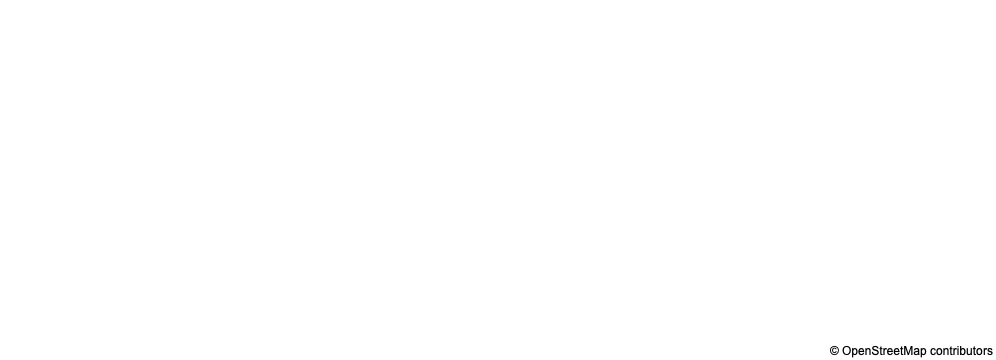

In [31]:
import pandas as pd
import plotly.express as px

fig = px.scatter_mapbox(resultQuery, lat="placeAlt", lon="placeLong", hover_name="placeName", hover_data=["numPeopleVisited", "placeAddress"],
                        color_discrete_sequence=["fuchsia"], zoom=3, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# **5. BONUS: More complex search engine**

The idea, is to let the user choose a number from 1 to 5 to specify one of the points 1-5. When he prints 0 the query is finished. He can't choose the same number twice. The result of the query is updated time to time as soon as the user gives a new specific.

First of all, let's start with the preparation of the dataset for this new query and with the definition of the functions useful for this question.<br>
So, we are going to stem all the columns that we have to analyze (except for the ``placeEditors``)

The inverted Index for the ``placeDesc`` is already prepared. Let's create the inverted indeces also for ``placeName`` and ``placeAddress``.

In [35]:
def create_dictio_and_invIdx(words):
    dictio = {}
    item_id = 1
    for word in words:
        dictio[word] = item_id
        item_id += 1
        
    inverted_idx = {}
    for word, item_id in dictio.items():
        inverted_idx[item_id] = list(queryData_5[queryData_5.placeName.apply(lambda row: word in row)].index)
    
    return (dictio, inverted_idx)

In [36]:
#preparation of the dataset

#take only the columns of interest
queryData_5 = queryDataCopy[['placeName', 'placeTags', 'wordsInDocs', 'placeAddress', 'numPeopleVisited',
                           'placeEditors','placeRelatedLists', 'placeURL']]

#replace eventual NaN values with the empty string
queryData_5 = queryData_5.fillna('')

#replace these columns with their stemmed values
columns_to_stem = ['placeTags', 'placeRelatedLists', 'placeName', 'placeAddress']

for col in columns_to_stem:
    stemmed = []
    for i in queryData_5[col]:
        queryDataStr = ''.join(c for c in i if c not in string.punctuation)
        queryDataProcess = preProcess(queryDataStr)
        stemmed.append(queryDataProcess)
    queryData_5[col] = stemmed
    if col=='placeName':
        sumListWords = list(set(functools.reduce(lambda x, y: x + y,stemmed)))
        name_dictionary, name_inv_idx = create_dictio_and_invIdx(sumListWords)

        # Create a file named vocabulary, with json format, that maps each word to an integer (term_id).
        with open ('vocabulary_name.json', 'w',encoding = 'utf-8') as j:
            j.write(json.dumps(name_dictionary))

        # storing inverted_idx in a separate file
        with open ('invertedIdx_name.json', 'w',encoding = 'utf-8') as j:
            j.write(json.dumps(name_inv_idx))
            
    if col=='placeAddress':
        sumListWords = list(set(functools.reduce(lambda x, y: x + y,stemmed)))
        address_dictionary, address_inv_idx = create_dictio_and_invIdx(sumListWords)

        # Create a file named vocabulary, with json format, that maps each word to an integer (term_id).
        with open ('vocabulary_address.json', 'w',encoding = 'utf-8') as j:
            j.write(json.dumps(address_dictionary))

        # storing inverted_idx in a separate file
        with open ('invertedIdx_address.json', 'w',encoding = 'utf-8') as j:
            j.write(json.dumps(address_inv_idx))

In [123]:
import json
#retrieve vocabulary and inverted index
with open('vocabulary_name.json', 'r',encoding = 'utf-8') as f:
    name_dictionary = json.load(f)
with open('invertedIdx_name.json', 'r',encoding = 'utf-8') as f2:
    name_inv_idx = json.load(f2)
    
with open('vocabulary_address.json', 'r',encoding = 'utf-8') as f:
    address_dictionary = json.load(f)
with open('invertedIdx_address.json', 'r',encoding = 'utf-8') as f2:
    address_inv_idx = json.load(f2)

For the point 1, let's define a new Search Engine that will retrieve only the rows that satisfy all the specifics.

In [43]:
def SearchEngine_Bonus(name, desc, address, dataframe):

    # Stem the words of the query
    stemName = set(preProcess(name))
    stemDesc = set(preProcess(desc))
    stemAddr = set(preProcess(address))

    # Find the description Ids of the queryString(documents that contain the queryString)
    results_desc = [set(inverted_idx[item]) for item in [wordDict[word] for word in stemDesc]]
    descId = functools.reduce(lambda x,y: x.intersection(y), results_desc) #Set of ids
    
    #Find the names Ids of the query string
    results_name = [set(name_inv_idx[item]) for item in [name_dictionary[word] for word in stemName]]
    nameId = functools.reduce(lambda x,y: x.intersection(y), results_name)
    
    #Find the address Ids of the query string
    results_address = [set(address_inv_idx[item]) for item in [address_dictionary[word] for word in stemAddr]]
    addressId = functools.reduce(lambda x,y: x.intersection(y), results_address)
    
    set_id = nameId.intersection(descId.intersection(addressId))
    queryInfo = dataframe.loc[set_id]
  
    return queryInfo

For the other points we can simply define some filters

In [44]:
def filter_usernames(users, dataframe):
    return dataframe[set(users).issubset(set(dataframe.placeEditors))]

def filter_tags(tags, dataframe):
    stem = preProcess(tags)
    return dataframe[set(stem).issubset(set(dataframe.placeTags))]

def filter_people(lowerbound, upperbound, dataframe):
    return dataframe[(dataframe.numPeopleVisited > int(lowerbound)) & (dataframe.numPeopleVisited < int(upperbound))]

def filter_list(lists, dataframe):
    stem = preProcess(lists)
    return dataframe[set(stem).issubset(set(dataframe.placeRelatedLists))]
        

In [58]:
questions = [1,2,3,4,5]

text = 'Hi user, please insert a number from 1 to 5. Enter 0 if you want to quit.\n'\
+ 'Choose 1 to specify the name of the place, the description and the adddress; all separated by a comma.\n'\
+ 'Choose 2 to specify the usernames to retrieve only the posts where these users contribuited to.\n'\
+ 'Choose 3 to specify a list of tags to retrieve only the places that are tagged.\n'\
+ 'Choose 4 to filter the output in terms of the number of people who have already been there.\n'\
+ 'Choose 5 to filter the output in base of which lists it is present into.\n'\

val = int(input(text))
result = queryData_5

while (val != 0):
    if len(questions)==0:
        break
    if val==1 and val in questions:
        query = input('Enter the name, the description and the address.')
        questions.remove(val)
        name, desc, address = query.split(',')
        result = SearchEngine_Bonus(name, desc, address, result)
    elif val==2 and val in questions:
        query = input('Enter the usernames.')
        questions.remove(val)
        users = query.split(',')
        result = filter_usernames(users, result)
    elif val==3 and val in questions:
        query = input('Enter the tags.')
        questions.remove(val)
        result = filter_tags(query, result)
    elif val==4 and val in questions:
        query = input('Enter the upperbound and the lowerbound.')
        questions.remove(val)
        up, low = query.split(',')
        result = filter_people(low, up, result)
    elif val==5 and val in questions:
        query = input('Enter the list names.')
        questions.remove(val)
        result = filter_list(query, result)
    val = int(input(text))

Hi user, please insert a number from 1 to 5. Enter 0 if you want to quit.
Choose 1 to specify the name of the place, the description and the adddress; all separated by a comma.
Choose 2 to specify the usernames to retrieve only the posts where these users contribuited to.
Choose 3 to specify a list of tags to retrieve only the places that are tagged.
Choose 4 to filter the output in terms of the number of people who have already been there.
Choose 5 to filter the output in base of which lists it is present into.
 4
Enter the upperbound and the lowerbound. 700,600
Hi user, please insert a number from 1 to 5. Enter 0 if you want to quit.
Choose 1 to specify the name of the place, the description and the adddress; all separated by a comma.
Choose 2 to specify the usernames to retrieve only the posts where these users contribuited to.
Choose 3 to specify a list of tags to retrieve only the places that are tagged.
Choose 4 to filter the output in terms of the number of people who have alrea

In [59]:
#print the result of the query
result

,placeName,placeTags,wordsInDocs,placeAddress,numPeopleVisited,placeEditors,placeRelatedLists,placeURL
7,"[underground, tunnel, lo, angel]","[tunnel, subterranean, site, architectur, oddi...","[rest, countri, forc, go, dri, underneath, dow...","[320, w, templ, st, lo, angel, california, 900...",660,"['Rachel', 'Avoiding Regret', 'jondi letnap', ...","[world, top, 100, wonder, 2018, lo, angel, top...",https://www.atlasobscura.com/places/leadenhall...
31,"[mount, moriah, cemeteri]","[abandon, cemeteri, memento, mori, graveyard, ...","[southwest, philadelphia, abandon, mount, mori...","[6201, kingsess, ave, angora, philadelphia, pe...",661,"['Luke J Spencer', 'designosophy', 'merlin1075...","[unit, state, abandon, place, world, top, 100,...",https://www.atlasobscura.com/places/catacombes...
46,"[abandon, jazzland]","[abandon, amus, park, amus, park, shop, abando...","[august, 29th, 2005, hurrican, katrina, struck...","[12310, six, flag, parkway, new, orlean, louis...",608,"['Laetitia Barbier', 'peglegasus', 'Jazzland',...","[world, tour, abandon, amus, park, unit, state...",https://www.atlasobscura.com/places/wave-organ\n
65,"[museum, alchemist, magician, old, pragu]","[alchemi, magic, museum, collect, museum]","[pragu, citi, steep, histori, known, otherwis,...","[jánský, vršek, 8, pragu, czechia]",652,"['EricGrundhauser', 'DaytonDUI', 'SamR', 'tomp...","[9, place, experi, wonder, alchemi, world, top...",https://www.atlasobscura.com/places/leadenhall...
67,"[fairi, glen]","[fairi, fairytal, martian, landscap, landscap,...","[fairi, glen, one, isl, skye, ’, enchant, attr...","[a87, uig, isl, skye, scotland, unit, kingdom]",694,"['Kerry Wolfe', 'Collector of Experiences', 'M...","[30, world, spectacular, spiral, world, top, 1...",https://www.atlasobscura.com/places/secret-til...
...,...,...,...,...,...,...,...,...
6807,"[spout, horn]","[geyser, waterwork, geolog, odditi, natur, won...","[consid, phenomenon, natur, beauti, awe, huge,...","[4550, lawai, rd, koloa, hawaii, 96756, unit, ...",627,"['btumpak', 'Rachel', 'Martin', 'superbliss3',...",[],https://www.atlasobscura.com/places/evolution-...
6994,"[arlington, hotel]","[hot, spring, place, stay, hotel, water, histori]","[natur, hot, spring, right, middl, resort, tow...","[hot, spring, arkansa, unit, state]",614,"['seh256', 'viventlesfees', 'breaingram', 'kmo...","[ultim, guid, america, nation, park]",https://www.atlasobscura.com/places/wave-organ\n
7023,"[museumsquarti, passag]","[public, mural, art, museum, architectur]","[7th, district, vienna, museumsquarti, collect...","[museumsplatz, 1, vienna, 1070, austria]",639,"['leiris', 'richgibson']",[],https://www.atlasobscura.com/places/wave-organ\n
7136,"[plimoth, patuxet]","[coloni, america, coloni, nativ, american, mus...","[’, ever, curiou, life, realli, like, 17th-cen...","[137, warren, ave, plymouth, massachusett, 023...",610,"['keslar', 'Isabella Connor', 'linkogecko']",[],https://www.atlasobscura.com/places/wave-organ\n


# **6. Command line**

It follows the code used in the command line question. In the Github repository you can find the .sh original runnable file.

# **7. Theoretical question**

# **7.1)**

In [60]:
import time

In [77]:
with open("ApplicantsInfo.txt", 'r') as f:
    file = f.read()

In [78]:
N = file.split()[0]
M = file.split()[1]
studenti = file.split("\n")

Let's compute the average of the grades and create a new list which contains name, surname, average grades for each student belonging to 'ApplicantsInfo.txt'.

In [75]:
def primaFunzione(studenti):
    new_list =[]
    for i in range(1, int(N)+1):
        arr = []
        stud = studenti[i].split()
        lista_voti = stud[2:]
        arr.append(stud[0])
        arr.append(stud[1])
        media = myMedia(lista_voti)
        arr.append(media)
        new_list.append(arr)
    return new_list
    
    
def myMedia(lista):
    count = 0
    val = 0
    for x in lista:
        val += int(x)
        count += 1
    return round(val/count,2)

lista = primaFunzione(studenti)

What this function does is to take two names as input (that can be even surnames when two students have the same name), if the first is lower than the second one (alphabetically speaking) than the funcion will return 1, otherwise 0. So, if two students have the same average of the grades, if this function will return 1 means that the first student (name1) has to go before than the second student (name2) in the list sorted. 

In [65]:
def sort_name_surname(name1,name2):
    if name1<name2:
        return 1
    elif name1>name2:
        return 0
    elif name1 == name2:
        return 0

**FIRST SORTING ALGORITHM (SORT1)**

The following algorithm, called 'sort1' compares the first element with all the others at the first iteration and puts the largest in the head; at the second iteration compares the second element with all the others and puts the second largest in second position, etc. .. If two average marks are equal, then this algorithm sort the students by their name and possibly by surname (if they have average marks and the same name). So at the end of for loops we will have the list sorted.

In [66]:
# 1.
# First type of sorting  
def sort1(lista):
    for j in range(len(lista)):
        for k in range(j+1, len(lista)):
            if lista[j][2] < lista[k][2]:
                lista[j], lista[k] = lista[k], lista[j]
            if lista[j][2] == lista[k][2]:
                if lista[j][0]==lista[k][0]:
                    count = sort_name_surname(lista[j][1],lista[k][1])
                elif lista[j][0]!=lista[k][0]:
                    count = sort_name_surname(lista[j][0],lista[k][0])
                if count==0:
                    lista[j], lista[k] = lista[k], lista[j]
    return lista

**SECOND SORTING ALGORITHM (MERGESORT)**

Mergesort algorithm defines two functions: merge and mergesort.


*   In the first we have to merge two ordered sequences.
The main observation is that the minimum of the merged sequence is the smaller of the minimum of the two sequences. Therefore, two indexes are maintained which take into account the elements still to be merged and the one which indexes the smallest element is advanced. When one of the two subsequences is exhausted, then the remainder of the other is queued. The merge function uses an additional temporary list to do the merge, so at the end the data on the temporary list must be copied to the initial list.
*  In the mergesort function we split the list step by step up to have a single element on which we can apply merge function.

In [67]:
# 2.
# Second type of sorting
def mergesort(lista, start = 0, end = None):
    if end is None:
        end = len(lista) - 1
    if start >= end:
        return
    mid = (end + start)//2
    mergesort(lista, start, mid)
    mergesort(lista, mid + 1, end)
    merge(lista, start, mid, end)
    return lista

def merge(lista,low, mid, high):
    a = low
    b = mid + 1
    temp = []
    #identify the smallest element step by step and add it to the list 'temp'.
    while ((a<=mid) and (b<=high)):
        if lista[a][2] > lista[b][2]:
            temp.append(lista[a])
            a += 1
        elif lista[a][2] < lista[b][2]:
            temp.append(lista[b])
            b += 1
        elif lista[a][2]==lista[b][2]:
            if lista[a][0]==lista[b][0]:
                count = sort_name_surname(lista[a][1],lista[b][1])
            elif lista[a][0]!=lista[b][0]:
                count = sort_name_surname(lista[a][0],lista[b][0])
            if count==1:
                temp.append(lista[a])
                a+=1
            elif count==0:
                temp.append(lista[b])
                b+=1       
    #exactly one sequence is exhausted, we must add the other
    if a<= mid:
        residuo = range(a, mid+1)
    else:
        residuo = range(b, high+1)
    for i in residuo:
        temp.append(lista[i])
    #we copy what we have into temp list, in the starting list 'lista'
    for i in range(len(temp)):
        lista[low+i] = temp[i]
    return lista

**THIRD SORTING ALGORITHM (QUICKSORT)**

Quicksort algorithm defines three functions: partition, quicksort and comparator.

- in the partition function we choose random an element of the list that we will call pivot. Then, once we have positioned the pivot as the first element of the list, we scroll the list from the beginning to the center and from the end to the center and if in the first case we find an element smaller than the pivot, then we exchange it with an element larger than the pivot that we find by scrolling the list from the end to the center. This is repeated until the two counters that scroll through the list from the beginning to the center and from the end to the center meet. Then we also go to order the pivot that we had placed at the beginning of the list.
- the comparator function takes two arguments as input and returns the larger of them if the arguments are numeric. If the two arguments are alphabetical, it returns the one that comes first in alphabetical order.
- In the quicksort function we divide the list step by step and we apply the funciont partition every time.


In [68]:
# 3.
# Third type of sorting
import random

#returns 1 if pivot is smaller or equal, 0 if greater
def comparator(element1, element2):
    if element2[2]!=element1[2]: return element2[2]>element1[2]
    if element2[0]!=element1[0]: return element2[0]<element1[0]
    return element2[1]<element1[1]

def quicksort(lista, start = 0, end = None):
    if end is None:
        end = len(lista) - 1
    if start < end:
        pivot_pos = partition(lista, start, end)
        quicksort(lista, start, pivot_pos -1)
        quicksort(lista, pivot_pos + 1, end)
        return lista

def partition(lista, start, end):
    #chooses a random position for the pivot
    pivot_pos = random.randint(start, end)
    pivot = lista[pivot_pos]
    #swap the pivot with the leading element
    lista[start], lista[pivot_pos] = lista[pivot_pos], lista[start]
    i = start + 1
    j = end
    #scan the list from the beginning (pivot excluded) towards the center and from the end towards the center
    while i<j:
        while i<j and comparator(pivot, lista[i]):
            i += 1 
        while i<j and not comparator(pivot, lista[j]):
            j -= 1
        if i<j:  #if it has found a pair to trade, he swaps it
            lista[i], lista[j] = lista[j], lista[i]
                    
    #if i has straddled the large elements, then the last small element (to be swapped with the pivot) is in position i-1, otherwise it is in position i
    if lista[i][2] <= pivot[2]:
        i -= 1
    lista[start], lista[i] = lista[i], lista[start]
    return i

Let's create a **RankingList.txt**

In [69]:
ranking = quicksort(lista)

In [70]:
final_ranking = open('RankingList.txt','w')
final_ranking.write(str(ranking) + '\n')
final_ranking.close()

# **7.2)**

# **Sort1**

Sort1 is an algorithm that works as follows:
- at the first iteration it compares the first element with all the others in the list, at the second iteration it compares the second element with all the others in the list ecc...

To do this, sort1 uses two for loops, so the **running time** is equal to $\Theta(n ^ {2})$

# **Mergesort**

Mergesort is a comparison sorting algorithm that proceeds as follows:
- divide the input into two parts
- order each part individually
- merge the two ordered sequences

To solve the smaller parts, the same method is reused, and then a hierarchy of applications of the method is generated, nested within each other, on smaller and smaller input parts, up to parts so small that they can be processed directly. .

### **Running time**
In this algorithm T (n), i.e. the number of operations necessary to sort a list of n elements is equal to:
T (n) = 2T (n / 2) + $\Theta(n)$

From here, we find that the **running time** is equal to theta $\Theta(nlog(n))$

# **Quicksort**

Quicksort is a comparison sorting algorithm that proceeds as follows:
- choose a random element of the list to be sorted (which we will call pivot for convenience). To avoid the worst case occurring, it is preferable to choose the pivot completely randomly among the items to be ordered.
- permute the elements to be ordered in such a way that all the minor elements of the pivot are found before it, and all the major elements of the pivot are after it.
- order the minor elements of the pivot
- order the major elements of the pivot

As in the case of mergesort, to sort the minor and major elements of the pivot, the Quicksort is reused again, and therefore a hierarchy of algorithm applications is generated nested one inside the other on smaller and smaller input parts, up to portions composed of a single element, which are obviously already ordered portions.

### **Running time**
The execution time of the Quicksort depends on how the partition method from time to time separates the portion to be sorted into two parts. Unlike the mergesort, the two portions can have different sizes. The partition method is executed on each portion to be sorted.

To calculate the running time of the Quicksort, two cases must be distinguished:

The **best case** occurs when each time the partition method is executed, the pivot is the element that in the sorted list is exactly in the middle of the list. In this case the **running time** is identical to that of the mergesort, equal to  $\Theta(nlog(n))$

The **worst case** occurs when in each execution of the partition method the minimum or maximum of the elements of the portion to be sorted is chosen as a pivot. In this case the **running time** is equal to  $\Theta(n ^ {2})$

# **7.3)**

**Sort1:**

In [71]:
import time
start_time = time.process_time()
sort1(lista)
end_time = time.process_time()
print('The time taken sorting the list with the sort1 algorithm is: ', round(end_time-start_time,2)//60, 'minutes and', round(end_time-start_time,2)%60, 'seconds')

The time taken sorting the list with the sort1 algorithm is:  6.0 minutes and 42.00999999999999 seconds


**Mergesort:**

In [76]:
start_time = time.process_time()
mergesort(lista)
end_time = time.process_time()
print('The time taken sorting the list with the mergesort algorithm is: ', round(end_time-start_time,2), 'seconds')

The time taken sorting the list with the mergesort algorithm is:  0.99 seconds


**Quicksort:**

In [79]:
start_time = time.process_time()
quicksort(lista)
end_time = time.process_time()
print('The time taken sorting the list with the quicksort algorithm is: ', round(end_time-start_time,2), 'seconds')

The time taken sorting the list with the quicksort algorithm is:  0.58 seconds


# **7.4)**

To find the most optimal algorithm we look at the running time and the execution time of the algorithms. We immediately exclude the first sorting algorithm (sort1) because it has a running time of theta $\Theta(n ^ {2})$. As for the other two, although both Mergesort and Quicksort have a running time of $\Theta(nlog(n))$ and particularly the second in the worst case has a running time of $\Theta(n ^ {2})$, I think **Quicksort is the best** of the three algorithms for the following reasons:
- the worst case in Quicksort is very rare to occur
- the execution time of Quicksort after multiple tests is less than that of Mergesort
-in Quicksort the internal while loop compares different values with only one at each iteration (i.e. with the pivot which is fixed and does not change), while in the mergesort the while loop compares two different values at each iteration. For this reason, Quicksort performs half as many reads as Mergesort.

# **7.5)**

**Note**: These cells where run using a PySpark kernel. In the Github repository there is also the official script.

First thing first, let's read the file.

In [42]:
students = sc.textFile('s3://adm22/ApplicantsInfo.txt')
#extract first row
drop = students.first()
#drop first row
students = students.filter(lambda row: row != drop)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now, let's define an useful function for the mapping part of the mapReduce approach. This function will calculate the mean of the grades for every student, and will return a tuple key-element, in which the key is the mean and the element the name.

In [51]:
def calculate_mean(row):
    student = row.split()
    grades = np.array(student[2:], dtype = np.int32)
    mean = sum(grades)/len(grades)
    #return (round(mean,2), (student[0], student[1]))
    return [student[0], student[1], round(mean,2)]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

At this point, we can proceed with the mapReduce algorithm. 

In [ ]:
students.map(lambda row: calculate_mean(row))\
.takeOrdered(50000, lambda x: (-x[2], x[0], x[1]))